# 实践题二
# 1）仅使用numpy实现三层神经网络BP训练算法(输入d维向量，中间h个隐含神经元，输出c>1类单热向量编码，隐含层使用sigmoid激活函数，输入输出层使用线性激活函数)，损失函数用均方误差或者交叉熵损失函数。

In [1]:
# import library
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

# 我设计的神经网络采用了静态图架构，即需要在训练前将网络连接关系建立好。
# 并且我设计了三个父类分别为层类Hlayer、损失函数类Hloss、优化器类Hoptimizer，不同的连接层与需要使用的损失函数和优化器就对这些父类进行继承。

In [2]:
# 层父类
class Hlayer(object):
    
    def __init__(self, trainable=True):
        self.trainable = trainable        # 表示这层是否有可训练参数
        self.input = None                # 记录层输入
        self.output = None               # 记录层输出
        self.upstream_gradient =  None   # 上游梯度
        self.downstream_gradient = None  # 下游梯度
        
    def __call__(self, input):           # 可直接调用层计算得到输出
        pass
    
    def backward(self):                  # 反向传播计算梯度 
        pass
     
    def summary(self):                   # 打印该层信息
        pass

In [3]:
# 损失函数父类
class Hloss(object):
    
    def __init__(self):
        self.input = None               # 记录损失函数的输入
        self.label = None               # 记录数据真实标签
        self.output = None              # 记录损失函数输出
        self.gradient = None            # 下游梯度
        
    def __call__(self, input, label):   # 可直接调用损失函数进行计算
        pass
    
    def backward(self):                 # 反向传播计算梯度
        pass
    
    def summary(self):                  # 打印损失函数信息
        pass

In [4]:
# 优化器父类
class Hoptimizer(object):
    
    def __init__(self, learning_rate=0.001):
        self.learning_rate = learning_rate # 默认优化器只有学习率一个参数
        
    def __call__(self, gradient):          # 直接调用优化器计算优化梯度
        pass

## 输入层
* 不可训练
* input=output

In [5]:
class Hinput(Hlayer):
    
    def __init__(self):
        super(Hinput, self).__init__()
        self.trainable = False
        
    def __call__(self, input):
        # print("input", input.shape)
        self.input = input
        self.output = input
        return self.output
    
    def backward(self):
        try:
            assert self.upstream_gradient is not None
        except AssertionError:
            print("ERROR! There is no upstream gradient!")
        else:
            self.downstream_gradient = self.upstream_gradient
            return self.downstream_gradient
        
    def summary(self, i):
        print("{:>15} {:>15} {:>15} {:>15}".format("Input-%d"%i, "[-1, -1]", str(self.trainable), 0))

## Sigmoid函数层
* 不可训练
![img](./img/Sigmoid.png)

In [6]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

class Hsigmoid(Hlayer):
    
    def __init__(self):
        super(Hsigmoid, self).__init__()
        self.trainable = False
    
    def __call__(self, input):
        # print(input.shape)
        self.input = input
        self.output = sigmoid(input)
        return self.output

    def backward(self):
        try:
            assert self.upstream_gradient is not None
        except AssertionError:
            print("ERROR! There is no upstream gradient!")
        else:
            self.downstream_gradient = self.upstream_gradient*sigmoid(self.input)*(1-sigmoid(self.input))
            return self.downstream_gradient
        
    def summary(self, i):
        print("{:>15} {:>15} {:>15} {:>15}".format("Sigmoid-%d"%i, "[-1, -1]", str(self.trainable), 0))

## 线性全连接层
* 可训练
* y=wx+b

In [7]:
class Hlinear(Hlayer):
    
    def __init__(self, input_size, output_size):
        """
            input_size:输入维度
            output_size:输出维度
        """
        super(Hlinear, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.trainable = True
        self.local_gradient = None
        self.w = np.random.randn(input_size+1, output_size)
        
    def __call__(self, input):
        # print(input.shape)
        input = np.concatenate((input, np.ones((input.shape[0], 1))), axis=1)
        self.input = input
        self.output = np.matmul(input, self.w)
        return self.output

    def backward(self):
        try:
            assert self.upstream_gradient is not None
        except AssertionError:
            print("ERROR! There is no upstream gradient!")
        else:
            self.local_gradient = np.matmul(np.transpose(self.input), self.upstream_gradient)
            self.downstream_gradient = np.matmul(self.upstream_gradient, np.transpose(self.w))
            self.downstream_gradient = self.downstream_gradient[:,:-1]  # 不需要将bias相关输出作为下游梯度
            return self.downstream_gradient
    
    def update(self, optimizer):
        self.w -= optimizer(self.local_gradient)
        
    def summary(self, i):
        print("{:>15} {:>15} {:>15} {:>15}".format("Linear-%d"%i, "[-1,%d]"%self.output_size, str(self.trainable), np.size(self.w)))
    
    def init_w(self):
        pass

## 交叉熵损失函数

In [8]:
def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1).reshape(len(exp_x),1)

def convert_to_one_hot(label,class_num):
    label = np.eye(class_num)[label]
    return label

class HCrossEntropy(Hloss):
    
    def __init__(self):
        super(HCrossEntropy, self).__init__()
    
    def __call__(self, input, label):
        """
            input:
            label:默认为input第二维度上的数量为分类的数量，采用one-hot编码对label进行编码
        """
        # print(input.shape)
        class_num = input.shape[1]  # 默认input第二维度上的数量为分类的数量
        label = convert_to_one_hot(label, class_num)  # 采用one-hot编码对label进行编码
        self.input = input
        self.label = label
        input = softmax(input)
        self.output = (-1)*np.sum(np.log(input)*label)
        return self.output
        
    def summary(self):
        print("Loss function: Cross Entropy")
    
    def backward(self):
        self.gradient = softmax(self.input) - self.label
        return self.gradient

## sgd随机梯度下降优化器
* 输入学习率

In [9]:
class Hsgd(Hoptimizer):
    
    def __init__(self, learning_rate):
        super(Hsgd, self).__init__(learning_rate)
        
    def __call__(self, gradient):
        return gradient*self.learning_rate

## 神经网络类定义
### 使用列表sequential存储堆叠的层
### criterion存储神经网络最后使用的损失函数
* add_layer函数用于添加实例化层
* add_criterion函数用于添加损失函数
* 可直接调用网络实例化对象计算输出结果
* loss函数得到网络损失函数输出
* predict函数得到网络分类编号输出
* backward函数反向传播计算网络可训练层梯度
* step函数对网络可训练层使用指定优化器进行参数更新
* summary函数可以打印网络实例化对象基本信息

In [10]:
class Hfnn:
    
    def __init__(self):
        self.sequential = []
        self.len_sequential = 0
        self.criterion = None
        
    def add_layer(self, layer):  # 添加实例化层
        l = layer
        self.sequential.append(l)
        self.len_sequential += 1
        
    def add_criterion(self, criterion):  # 添加损失函数
        self.criterion = criterion
        
    def __call__(self, input):  # 可直接调用网络实例化对象计算输出结果
        x = input.copy()
        for layer in self.sequential:
            x = layer(x)
        return x
    
    def loss(self, output, label):  # 返回网络损失函数输出
        loss = self.criterion(output, label)
        return loss
    
    def predict(self, input):  # 得到网络分类编号输出
        output = self(input)
        pred = np.argmax(output, axis=1)
        return pred
    
    def backward(self):  # 反向传播计算网络可训练层梯度
        downstream_gradient = self.criterion.backward()
        for i in range(self.len_sequential-1, -1, -1):
            self.sequential[i].upstream_gradient = downstream_gradient
            downstream_gradient = self.sequential[i].backward()
            
    def step(self, optimizer):  # 根据梯度和指定的优化器更新可训练层网络参数
        for layer in self.sequential:
            if layer.trainable:
                layer.update(optimizer)
                
    def summary(self):  # 打印网络基本信息
        print('-'*64)
        print("{:>15} {:>15} {:>15} {:>15}".format("Layer (type)", "Output Shape", "Trainable", "Param #"))
        print('='*64)
        for i, layer in enumerate(self.sequential):
            layer.summary(i)
        print('='*64)
        self.criterion.summary()

# 2) 在iris数据集上对1中实现的算法测试，并于实践题1的结果进行比较

In [11]:
# 将特征变量和标签分开并打乱数据集
def shuffle_data(data, label):
    index = np.arange(len(label))
    np.random.shuffle(index)
    data = data[index, :]
    label = label[index]
    return data, label

In [12]:
# 划分80%训练数据和20%测试数据
def train_test_divide(data, label, proportion):
    """
        proportion: range from 0 to 1, means the proportion of training data in the total data
    """
    train_length = int(len(label)*proportion)
    train_data = data[:train_length, :]
    train_label = label[:train_length]
    test_data = data[train_length:, :]
    test_label = label[train_length:]
    print("Shape: train_data", train_data.shape,
          "|train_label", train_label.shape,
          "|test_data", test_data.shape,
          "|test_label", test_label.shape)
    
    return train_data, train_label, test_data, test_label

In [13]:
# 读取Iris数据集
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
iris_df = pd.read_csv('iris.data', names=names)
iris_df.head()
iris_data = iris_df.values[:,:-1].astype(np.float)
# 三类鸢尾花分别编号为 0，1，2
iris_label = pd.Categorical(iris_df['class']).codes.astype(np.float)

In [14]:
class training_process:
    def __init__(self, train_data, train_label, test_data, test_label, model, optimizer,
                  epoch=10):
        """
            train_data: 训练数据
            train_label: 训练数据标签
            test_data: 测试数据
            test_label: 测试数据标签
            model: 使用的模型
            criterion: 损失函数
            optimizer: 优化方法
            epoch: 训练轮数
        """
        self.train_data = train_data
        self.train_label = train_label
        self.test_data = test_data
        self.test_label = test_label
        self.model = model
        self.optimizer = optimizer
        self.train_size = len(train_label)
        self.test_size = len(test_label)
        self.epoch = epoch
        
        # 用来保存每次训练过程中训练集误差、测试集误差、训练集精度以及测试集精度
        self.loss_train = []
        self.loss_test = []
        self.acc_train = []
        self.acc_test = []
    
    # 清空已有的训练过程
    def clear(self):
        self.loss_train = []
        self.loss_test = []
        self.acc_train = []
        self.acc_test = []
        
    # 输出训练过程数据
    def checkpoint(self):
        return self.loss_train, self.loss_test, self.acc_train, self.acc_test
    
    # 定义训练过程
    def train(self):
        for epoch in tqdm(range(self.epoch)):
            # 正向传播计算误差
            train_outputs = self.model(self.train_data)
            train_loss = self.model.loss(train_outputs, self.train_label)
            # 反向传播计算梯度
            self.model.backward()
            # 优化器更新模型参数
            self.model.step(self.optimizer)

            self.loss_train.append(train_loss)
            # 测试模型在训练集和测试集上的精度以及计算在测试集上的loss
            train_correct = 0
            test_correct = 0
            test_outputs = self.model(self.test_data)
            test_loss = self.model.loss(test_outputs, self.test_label)

            train_predicted = self.model.predict(self.train_data)
            train_correct += (train_predicted == self.train_label).sum().item()

            test_predicted = self.model.predict(self.test_data)
            test_correct += (test_predicted == self.test_label).sum().item()
                
                    
            self.acc_train.append(train_correct/self.train_size*100)
            self.acc_test.append(test_correct/self.test_size*100)
            self.loss_test.append(test_loss)
            # 打印训练过程信息
            print('[epoch: %d]|training loss: %.6f| testing loss: %.6f' %
             (epoch + 1, train_loss, test_loss))
            print('Accuracy of the network on the train data: %.3f %%' % (train_correct/self.train_size*100)) 
            print('Accuracy of the network on the test data: %.3f %%' % (test_correct/self.test_size*100))

        print('Finished Training')
      
    # 作出四张图，分别是训练集误差曲线、测试集误差曲线、训练集精度曲线、测试集精度曲线
    def plot_loss_and_acc(self, figname):
        fig = plt.figure(figsize=(10, 16))
        # 训练集和测试集误差曲线
        ax1 = fig.add_subplot(211)
        ax1.plot(np.arange(self.epoch)+1, np.array(self.loss_train))
        ax1.plot(np.arange(self.epoch)+1, np.array(self.loss_test))
        ax1.set_xlabel('Steps')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss of the network on the training and testing data')
        ax1.legend(['Train', 'Test'])
        ax1.grid(True)

        # 训练集和测试集精度曲线
        ax2 = fig.add_subplot(212)
        ax2.plot(np.arange(self.epoch)+1, np.array(self.acc_train))
        ax2.plot(np.arange(self.epoch)+1, np.array(self.acc_test))
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Accuracy of the network on the training and testing data')
        ax2.legend(['Train', 'Test'])
        ax2.grid(True)
        
        plt.savefig('./img/%s_loss_acc.png' % figname)
        plt.show()

In [15]:
# 打乱数据集并进行80%训练和20%测试划分
iris_data, iris_label = shuffle_data(iris_data, iris_label)
train_data, train_label, test_data, test_label = train_test_divide(iris_data, iris_label, 0.8)
# 计算训练集数据均值和方差
train_mean = np.mean(train_data, axis=0)
train_std = np.std(train_data, axis=0)
# 预处理数据
train_data = (train_data - train_mean)/train_std
test_data = (test_data - train_mean)/train_std

train_label = train_label.astype(np.int)
test_label = test_label.astype(np.int)

Shape: train_data (120, 4) |train_label (120,) |test_data (30, 4) |test_label (30,)


# 构建三层神经网络实例化对象
## 输入层维度为4，隐藏层维度为12，输出层维度为3
![img](./img/my_fnn架构.JPG)

In [16]:
input_size = iris_data.shape[1]
output_size = 3

fnn = Hfnn()
fnn.add_layer(Hinput())
fnn.add_layer(Hlinear(4, 12))
fnn.add_layer(Hsigmoid())
fnn.add_layer(Hlinear(12, output_size))
fnn.add_criterion(HCrossEntropy())

fnn.summary()

----------------------------------------------------------------
   Layer (type)    Output Shape       Trainable         Param #
        Input-0        [-1, -1]           False               0
       Linear-1         [-1,12]            True              60
      Sigmoid-2        [-1, -1]           False               0
       Linear-3          [-1,3]            True              39
Loss function: Cross Entropy


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 694.48it/s]

[epoch: 1]|training loss: 277.669544| testing loss: 24.526313
Accuracy of the network on the train data: 64.167 %
Accuracy of the network on the test data: 70.000 %
[epoch: 2]|training loss: 117.912475| testing loss: 13.595875
Accuracy of the network on the train data: 65.000 %
Accuracy of the network on the test data: 70.000 %
[epoch: 3]|training loss: 65.578083| testing loss: 15.461510
Accuracy of the network on the train data: 67.500 %
Accuracy of the network on the test data: 70.000 %
[epoch: 4]|training loss: 68.641720| testing loss: 14.340279
Accuracy of the network on the train data: 65.833 %
Accuracy of the network on the test data: 70.000 %
[epoch: 5]|training loss: 72.060311| testing loss: 16.453964
Accuracy of the network on the train data: 68.333 %
Accuracy of the network on the test data: 70.000 %
[epoch: 6]|training loss: 71.701619| testing loss: 12.462752
Accuracy of the network on the train data: 65.833 %
Accuracy of the network on the test data: 70.000 %
[epoch: 7]|tra

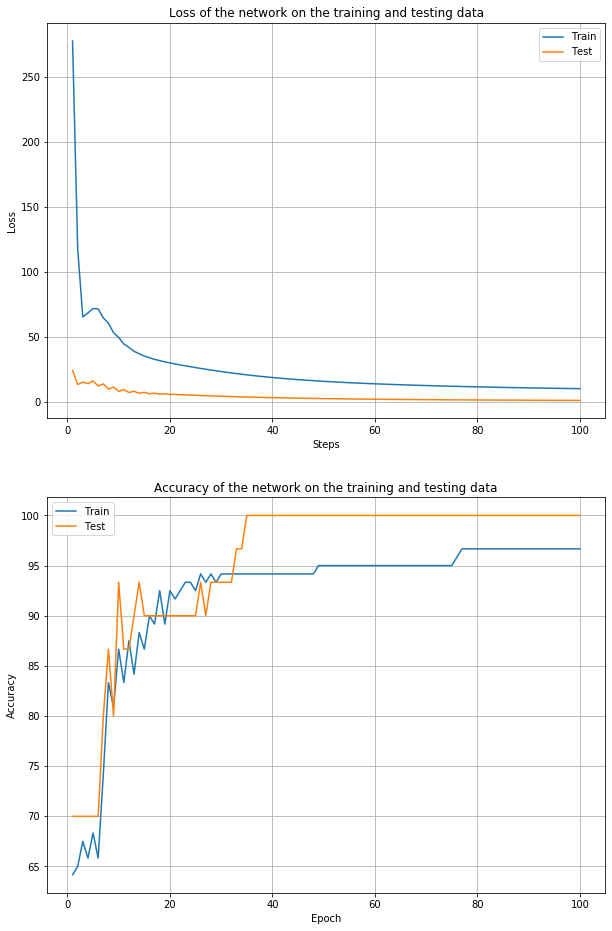

In [17]:
optimizer = Hsgd(learning_rate=0.014)
training1 = training_process(train_data, train_label, test_data, test_label, fnn, optimizer,
                  epoch=100)
training1.train()
training1.plot_loss_and_acc('My_fnn')